![](https://media.autoexpress.co.uk/image/private/s--8AcSVtN0--/f_auto,t_primary-image-desktop@1/v1654880627/buyacar/car-insurance-2.jpg)


# Library

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Image, display
from mpl_toolkits.mplot3d import Axes3D

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Utilities
from functools import partial
import warnings
import requests
import zipfile
import io
# Configure settings
warnings.filterwarnings("ignore")  # Ignore warnings
pd.set_option('display.max_columns', None)  # Display all DataFrame columns in outputs

In [ ]:
# import pandas as pd
# import geopandas as gpd
# import plotly.express as px
# from IPython.display import Image, display



# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D

# from functools import partial
# from sklearn.datasets import fetch_openml
# from sklearn.preprocessing import LabelEncoder

# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# import pandas as pd

# import warnings
# warnings.filterwarnings("ignore")
# pd.set_option('display.max_columns', None)

# import warnings

# warnings.filterwarnings("ignore")
# import seaborn as sns
# from functools import partial
# import matplotlib.pyplot as plt
# import pandas as pd

# import numpy as np


# Import Raw Data

In [2]:
def load_mtpl2(n_samples=None):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True).data

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


In [3]:
try:
    # load data from local pickle
    df = pd.read_pickle("mtpl2.pkl")
except FileNotFoundError:
    # or download from openml
    df = load_mtpl2()
    df.to_pickle("mtpl2.pkl")

df.to_csv('data_pgpc.csv')


# URL of the data
url = "https://www.data.gouv.fr/fr/datasets/r/c80259de-b310-45d3-8b3d-e9ec0861a2d8"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Extract the content of the response
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    # Extract all contents of the zip file into a directory
    zip_file.extractall("data")  # You can specify the directory where you want to extract the files
    zip_file.close()
    print("Data downloaded successfully.")
else:
    print("Failed to download data. Status code:", response.status_code)

df.shape

Data downloaded successfully.


(678013, 12)

# Data Overview

In [4]:
df.shape

(678013, 12)

In [5]:
df.head(2)

ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
1.0        1.0      0.10    D       5.0     0.0     55.0        50.0      B12   
3.0        1.0      0.77    D       5.0     0.0     55.0        50.0      B12   

        VehGas  Density Region  ClaimAmount  
IDpol                                        
1.0    Regular   1217.0    R82          0.0  
3.0    Regular   1217.0    R82          0.0

IDpol: policy number (unique identifier);

ClaimNb: number of claims on the given policy;

Exposure: total exposure in yearly units;

Area: area code (categorical, ordinal);

VehPower: power of the car (categorical, ordinal)

VehAge: age of the car in years;

DrivAge: age of the (most common) driver in years

BonusMalus: bonus-malus level between 50 and 230 (with reference level 100);

VehBrand: car brand (categorical, nominal);

VehGas: diesel or regular fuel car (binary);

Density: density of inhabitants per km2 in the city of the living place of the driver;

Region: regions in France (prior to 2016)

ClaimAmount: total claim amount.


In [6]:
df.ClaimNb.value_counts()

0.0     643953
1.0      32178
2.0       1784
3.0         82
4.0          7
11.0         3
5.0          2
6.0          1
8.0          1
16.0         1
9.0          1
Name: ClaimNb, dtype: int64

In [7]:
df.describe()

ClaimNb       Exposure       VehPower         VehAge  \
count  678013.000000  678013.000000  678013.000000  678013.000000   
mean        0.053247       0.528750       6.454631       7.044265   
std         0.240117       0.364442       2.050906       5.666232   
min         0.000000       0.002732       4.000000       0.000000   
25%         0.000000       0.180000       5.000000       2.000000   
50%         0.000000       0.490000       6.000000       6.000000   
75%         0.000000       0.990000       7.000000      11.000000   
max        16.000000       2.010000      15.000000     100.000000   

             DrivAge     BonusMalus        Density   ClaimAmount  
count  678013.000000  678013.000000  678013.000000  6.780130e+05  
mean       45.499122      59.761502    1792.422405  8.835998e+01  
std        14.137444      15.636658    3958.646564  5.822454e+03  
min        18.000000      50.000000       1.000000  0.000000e+00  
25%        34.000000      50.000000      92.000000  0.000000e+00  
50%        44.000000      50.000000     393.000000  0.000000e+00  
75%        55.000000      64.000000    1658.000000  0.000000e+00  
max       100.000000     230.000000   27000.000000  4.075401e+06

In [8]:
df.dtypes.value_counts()

float64     8
category    1
category    1
object      1
category    1
dtype: int64

In [9]:
df.isnull().sum()

ClaimNb        0
Exposure       0
Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
ClaimAmount    0
dtype: int64

# Exploratory Data Analysis

### Target variable 

In [10]:
def plotBarChart(data, x, ylimitFREQ):
    # Set the style and size
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 8))  # Increase figure size
    
    # Calculate Exposure and Frequency data
    EVY = data.groupby(x, as_index=False).agg({'Exposure': 'sum'})
    Freq = data.groupby(x, as_index=False).agg({'freq': 'mean'})
    
    # Create subplots
    fig, ax = plt.subplots(1, 2)
    
    # Exposure Plot
    sns.barplot(x=EVY[x], y=EVY['Exposure'], palette='coolwarm', ax=ax[0])
    ax[0].set_title(f"Total Exposure by {x}")
    ax[0].set_xlabel(x)
    ax[0].set_ylabel('Total Exposure')
    ax[0].tick_params(axis='x', rotation=45)
    
    # Frequency Plot
    sns.barplot(x=Freq[x], y=Freq['freq'], palette='coolwarm', ax=ax[1])
    ax[1].set_title(f"Average Frequency by {x}")
    ax[1].set_xlabel(x)
    ax[1].set_ylabel('Average Frequency')
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].set_ylim(0, ylimitFREQ)
    
    plt.tight_layout()
    plt.show()

In [11]:
values = np.array([0, 1, 2, 3, 4, 11, 5, 6, 8, 16, 9])

# Use reindex to align counts with the values array, filling missing values with 0
counts_series = df['ClaimNb'].value_counts()
counts = counts_series.reindex(values, fill_value=0).to_numpy()

non_zero_counts = counts[values != 0]
non_zero_values = values[values != 0]

# Zero vs Non-Zero Pie Chart Data Preparation
zero_count = counts[0]  # Assuming the first value is zero count
non_zero_sum = np.sum(non_zero_counts)
pie_labels = ['Zero Claims', 'Non-Zero Claims']
pie_sizes = [zero_count, non_zero_sum]
pie_colors = ['lightblue', 'lightgreen']
pie_explode = (0.1, 0)  # explode the 1st slice (Zero)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart
ax[0].pie(pie_sizes, explode=pie_explode, labels=pie_labels, colors=pie_colors,
          autopct='%1.1f%%', shadow=True, startangle=140)
ax[0].set_title('Proportion of Zero vs. Non-Zero Claims')

# Bar Plot for Non-Zero Values
colors = plt.cm.viridis(non_zero_counts / float(max(non_zero_counts)))
ax[1].bar(non_zero_values, non_zero_counts, color=colors)
ax[1].set_xlabel('Claim Number')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of Non-Zero Claims')
ax[1].set_xticks(non_zero_values)

plt.tight_layout()
plt.show()


#### independent variables by using PCA

In [16]:
df_pca=df.copy()
#df_pca=df_pca.drop('IDpol',axis=1)
label_encoders = {}
for column in ['Area', 'VehBrand', 'VehGas', 'Region']:
    le = LabelEncoder()
    df_pca[column] = le.fit_transform(df_pca[column])
    label_encoders[column] = le  # Store encoder to inverse transform or apply to new data


In [17]:
x = df_pca.drop('ClaimNb',axis=1)
y = df_pca['ClaimNb']

In [18]:
# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA with 3 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

# Variance explained by the PCA components
variance_explained = pca.explained_variance_ratio_
sum(variance_explained)

0.41456491366377934

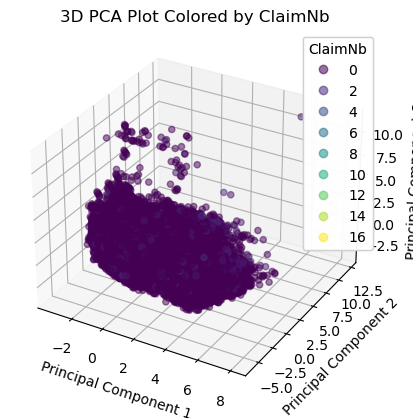

In [19]:
# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extend the PCA result to 3 dimensions for plotting purposes
pca_3d = PCA(n_components=3)
principalComponents_3d = pca_3d.fit_transform(x)

# Plotting
scatter = ax.scatter(principalComponents_3d[:, 0], principalComponents_3d[:, 1], principalComponents_3d[:, 2], c=y, cmap='viridis', alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(), title="ClaimNb")
ax.add_artist(legend1)
ax.set_title('3D PCA Plot Colored by ClaimNb')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()



### without Zeros

In [21]:
df_pca_non_zero=df_pca[df_pca['ClaimNb']!=0]
y = df_pca_non_zero['ClaimNb']
x = df_pca_non_zero.drop('ClaimNb',axis=1)
# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA with 3 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

# Variance explained by the PCA components
variance_explained = pca.explained_variance_ratio_
sum(variance_explained)

0.4098318637226985

In [22]:
pca = PCA(n_components=3)
components = pca.fit_transform(x)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(x)), opacity = 1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=500
)
fig.show()




In [ ]:
#fig.write_html("3D.html")

### Correlation Linear and Nonlineirty

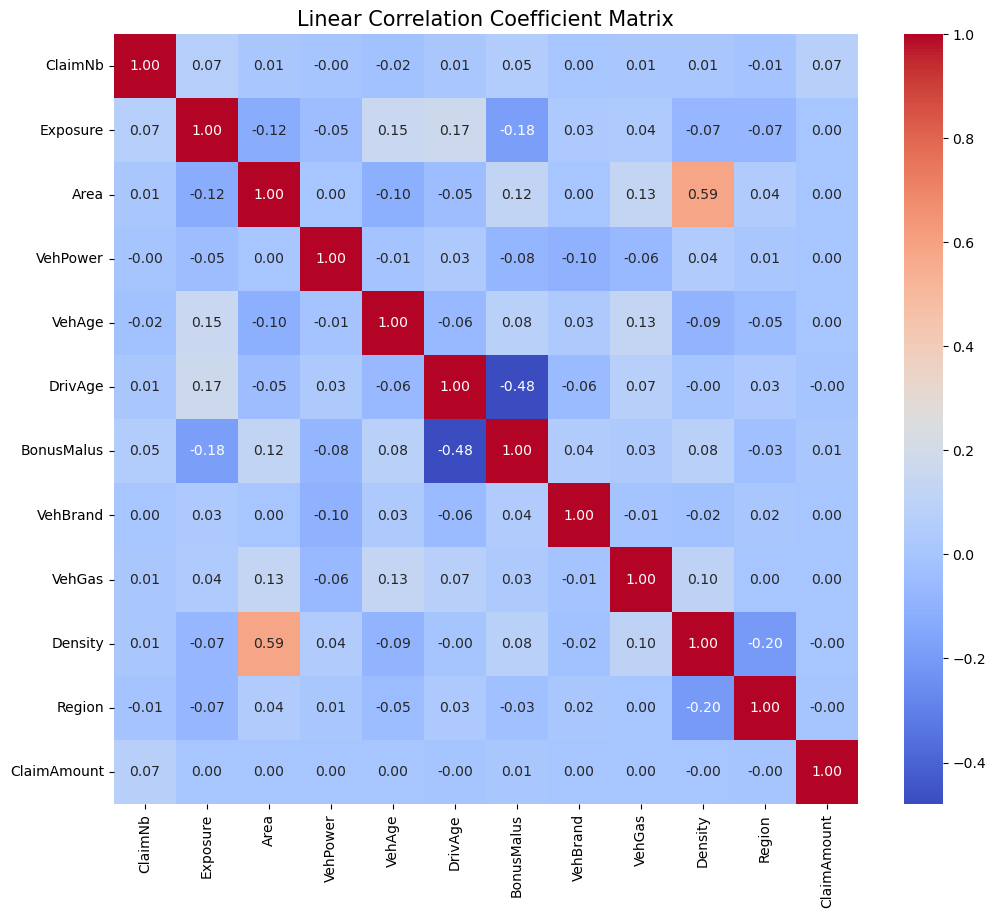

In [26]:
df_corr=df.copy()
#df_corr=df_corr.drop('IDpol',axis=1)
label_encoders = {}

for column in ['Area', 'VehBrand', 'VehGas', 'Region']:
    le = LabelEncoder()
    df_corr[column] = le.fit_transform(df_corr[column])
    label_encoders[column] = le 
    

df_corr.shape

linear_corr = df_corr.corr(method='pearson')
nonlinear_corr = df_corr.corr(method='spearman')
# Set up the matplotlib figure for linear correlation matrix
plt.figure(figsize=(12, 10))
plt.title('Linear Correlation Coefficient Matrix', fontsize=15)
sns.heatmap(linear_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

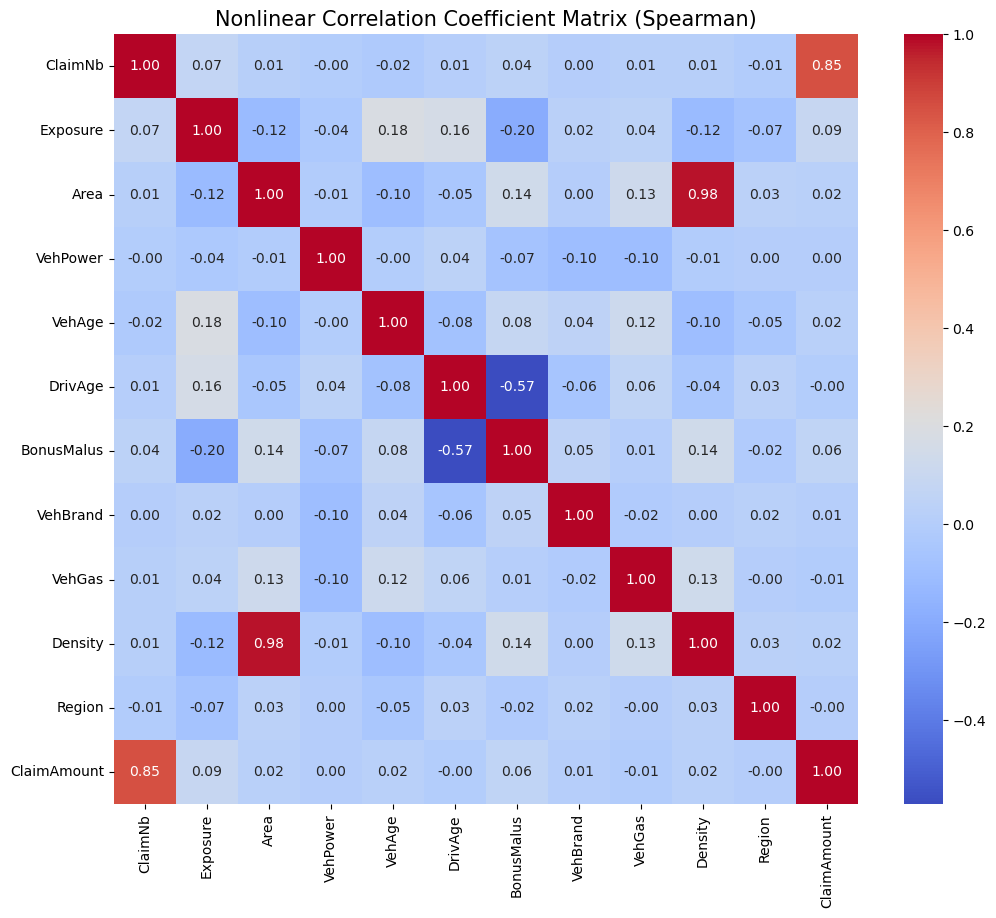

In [27]:
# Set up the matplotlib figure for nonlinear correlation matrix
plt.figure(figsize=(12, 10))
plt.title('Nonlinear Correlation Coefficient Matrix (Spearman)', fontsize=15)
sns.heatmap(nonlinear_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

## Feature Engineering 

In [28]:
df_transformed=df.copy()

In [29]:
df_transformed["Exposure"] = df_transformed["Exposure"].clip(upper=1)
df_transformed["ClaimAmount"] = df_transformed["ClaimAmount"].clip(upper=200000)
df_transformed["VehAge_clip"] = df_transformed["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df_transformed["DrivAge_clip"] = df_transformed["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))

df_transformed["Density"] = np.log(df_transformed["Density"])
df_transformed["VehAge2"] = df_transformed["VehAge"] ** 2
df_transformed["DrivAge2"] = df_transformed["DrivAge"] ** 2

df_transformed["VehAge3"] = df_transformed["VehAge"] ** 3
df_transformed["DrivAge3"] = df_transformed["DrivAge"] ** 3

df_transformed["VehAge4"] = df_transformed["VehAge"] ** 4
df_transformed["DrivAge4"] = df_transformed["DrivAge"] ** 4

df_transformed["VehAge5"] = df_transformed["VehAge"] ** 5
df_transformed["DrivAge5"] = df_transformed["DrivAge"] ** 5

df_transformed["VehAge6"] = df_transformed["VehAge"] ** 6
df_transformed["DrivAge6"] = df_transformed["DrivAge"] ** 6


The RiskFactorScore feature seems to be a composite metric intended to represent the combined risk associated with a policy, taking into account the power of the vehicle (VehPower), the age of the driver (DrivAge), the bonus-malus level (BonusMalus), and the population density of the area (Density). Each of these factors is first normalized to a 0-1 scale by subtracting the minimum value and dividing by the range (max - min), which is known as Min-Max normalization. After normalization, each factor is given an equal weight of 0.25 to contribute to the overall RiskFactorScore.

In [30]:
VehPower_min, VehPower_max = df_transformed['VehPower'].min(), df_transformed['VehPower'].max()
DrivAge_min, DrivAge_max = df_transformed['DrivAge'].min(), df_transformed['DrivAge'].max()
BonusMalus_min, BonusMalus_max = df_transformed['BonusMalus'].min(), df_transformed['BonusMalus'].max()
Density_min, Density_max = df_transformed['Density'].min(), df_transformed['Density'].max()


df_transformed['VehPower_normalized'] = (df_transformed['VehPower'] - VehPower_min) / (VehPower_max - VehPower_min)
df_transformed['DrivAge_normalized'] = (df_transformed['DrivAge'] - DrivAge_min) / (DrivAge_max - DrivAge_min)
df_transformed['BonusMalus_normalized'] = (df_transformed['BonusMalus'] - BonusMalus_min) / (BonusMalus_max - BonusMalus_min)
df_transformed['Density_normalized'] = (df_transformed['Density'] - Density_min) / (Density_max - Density_min)


df_transformed['RiskFactorScore'] = (df_transformed['VehPower_normalized'] +
                                     df_transformed['DrivAge_normalized'] +
                                     df_transformed['BonusMalus_normalized'] +
                                     df_transformed['Density_normalized']) / 4


Vehicle Age Category:
Convert VehAge into categorical bins to capture different lifecycle stages of a vehicle, such as new, mid-life, and old. This can help in understanding how vehicle age impacts claims differently across its lifespan.


In [31]:
df_transformed['VehAgeCategory'] = pd.cut(df_transformed['VehAge'], bins=[-1, 3, 7, 15, 100], labels=['New', 'Mid-life', 'Old', 'Very Old'])


Area Density Level:
Classify Density into categories such as Low, Medium, High, and Very High to better capture the effect of population density on claims.

In [32]:
density_bins = [0, df_transformed['Density'].quantile(0.25), df_transformed['Density'].quantile(0.5), df_transformed['Density'].quantile(0.75), df_transformed['Density'].max()]
df_transformed['AreaDensityLevel'] = pd.cut(df_transformed['Density'], bins=density_bins, labels=['Low', 'Medium', 'High', 'Very High'])


Interaction Between Driver Age and Vehicle Power:
An interaction feature between DrivAge and VehPower could capture the combined effect of driver age and vehicle power on claims. Younger drivers with powerful vehicles might represent a higher risk.

In [33]:
df_transformed['AgePowerInteraction'] = df_transformed['DrivAge'] * df_transformed['VehPower']

Driver Experience Level:
Create a feature that categorizes DrivAge into experience levels. Younger and very old drivers might have higher risks, which can be captured in such a categorical feature.

In [34]:
df_transformed['DriverExperienceLevel'] = pd.cut(df_transformed['DrivAge'], bins=[17, 25, 35, 50, 65, 100], labels=['Novice', 'Intermediate', 'Experienced', 'Senior', 'Very Senior'])


In [35]:
df_transformed['Log_Density'] = df_transformed['Density'].apply(lambda x: np.log(x + 1))


In [36]:
# Assuming high risk if ClaimAmount is above 75th percentile
high_risk_threshold = df_transformed['ClaimAmount'].quantile(0.75)
df_transformed['HighRiskArea'] = df_transformed['ClaimAmount'].apply(lambda x: 1 if x > high_risk_threshold else 0)


Standardization of Risk: Exposure typically represents the amount of time or the extent to which the policyholder was at risk, often measured in years. By dividing the number of claims by the exposure, you get a standardized measure of the frequency of claims that is independent of the time frame. This allows for a fair comparison between policyholders with different lengths of coverage.

Annualized Metric: If the exposure is measured in years, the freq variable effectively becomes the annual frequency of claims, which is a standard metric in insurance analytics. It tells you, on average, how many claims were made per year, which is useful for assessing risk and setting premiums.

Adjustment for Part-Year Policies: If a policyholder is only covered for part of a year, simply looking at the number of claims doesn't account for this reduced exposure. Creating a frequency feature adjusts for this and prevents the model from being biased against these policyholders.

Predictive Power: The claim frequency is often more predictive of future claims than the raw count of past claims, especially in a portfolio where exposure periods vary greatly. This is because frequency captures the underlying risk more accurately.

Rate Making: Insurance rates are often set based on the expected frequency of claims. By calculating the frequency, you are directly estimating the variable that is typically used to calculate insurance premiums.

Identification of Trends and Outliers: Normalizing the number of claims by exposure can help identify trends or outliers that may not be apparent from the raw counts. For example, a policy with a high number of claims but also a very high exposure might actually have a low risk once the frequency is calculated.

Risk Segmentation: freq can be used to segment the risks into different categories. For example, policies could be categorized as low, medium, or high frequency, which can then inform underwriting decisions or risk mitigation strategies.

In [ ]:
df_transformed['freq'] = df_transformed['ClaimNb']/df_transformed['Exposure']

In [ ]:
df_transformed['freq'].describe()

In [ ]:
df_transformed.dtypes.value_counts()

In [37]:
for column in [i for i in df_transformed.columns if df_transformed[f'{i}'].dtypes=='O' or df_transformed[f'{i}'].dtypes=='category']:
    le = LabelEncoder()
    df_transformed[column] = le.fit_transform(df_transformed[column])
    label_encoders[column] = le 


In [38]:
df_transformed.dtypes.value_counts()

float64    27
int64       8
dtype: int64

### Feature Distributions

In [40]:
# get frequency
df_transformed["freq"] = df_transformed["ClaimNb"] / df_transformed["Exposure"]

df_transformed.head(3)

ClaimNb  Exposure  Area  VehPower  VehAge  DrivAge  BonusMalus  \
IDpol                                                                   
1.0        1.0      0.10     3       5.0     0.0     55.0        50.0   
3.0        1.0      0.77     3       5.0     0.0     55.0        50.0   
5.0        1.0      0.75     1       6.0     2.0     52.0        50.0   

       VehBrand  VehGas   Density  Region  ClaimAmount  VehAge_clip  \
IDpol                                                                 
1.0           3       1  7.104144      17          0.0          0.0   
3.0           3       1  7.104144      17          0.0          0.0   
5.0           3       0  3.988984       2          0.0          2.0   

       DrivAge_clip  VehAge2  DrivAge2  VehAge3  DrivAge3  VehAge4   DrivAge4  \
IDpol                                                                           
1.0            55.0      0.0    3025.0      0.0  166375.0      0.0  9150625.0   
3.0            55.0      0.0    3025.0      0.0  166375.0      0.0  9150625.0   
5.0            52.0      4.0    2704.0      8.0  140608.0     16.0  7311616.0   

       VehAge5     DrivAge5  VehAge6      DrivAge6  VehPower_normalized  \
IDpol                                                                     
1.0        0.0  503284375.0      0.0  2.768064e+10             0.090909   
3.0        0.0  503284375.0      0.0  2.768064e+10             0.090909   
5.0       32.0  380204032.0     64.0  1.977061e+10             0.181818   

       DrivAge_normalized  BonusMalus_normalized  Density_normalized  \
IDpol                                                                  
1.0              0.451220                    0.0            0.696240   
3.0              0.451220                    0.0            0.696240   
5.0              0.414634                    0.0            0.390939   

       RiskFactorScore  VehAgeCategory  AreaDensityLevel  AgePowerInteraction  \
IDpol                                                                           
1.0           0.309592               1                 0                275.0   
3.0           0.309592               1                 0                275.0   
5.0           0.246848               1                 1                312.0   

       DriverExperienceLevel  Log_Density  HighRiskArea       freq  
IDpol                                                               
1.0                        3     2.092376             0  10.000000  
3.0                        3     2.092376             0   1.298701  
5.0                        3     1.607232             0   1.333333

<Figure size 2000x800 with 0 Axes>

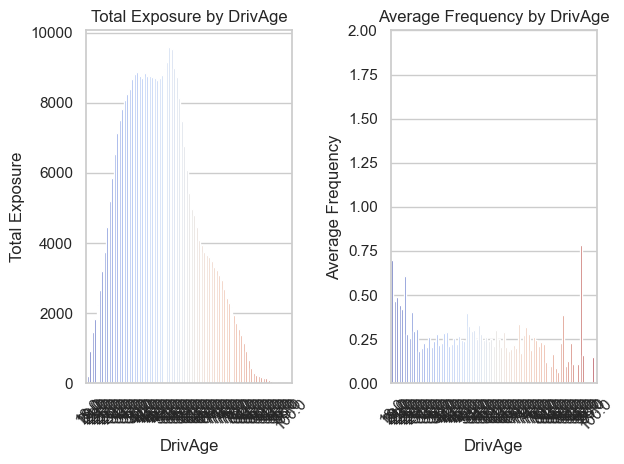

In [41]:
plotBarChart(df_transformed,'DrivAge',2)

<Figure size 2000x800 with 0 Axes>

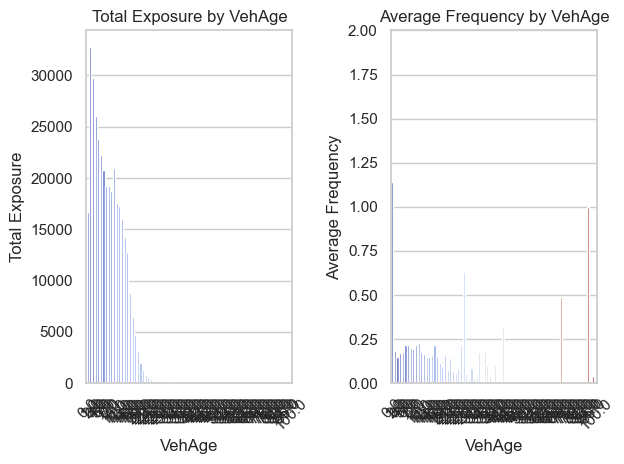

In [42]:
plotBarChart(df_transformed,'VehAge',2)

In [43]:
plotBarChart(df_transformed,'BonusMalus',2)

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

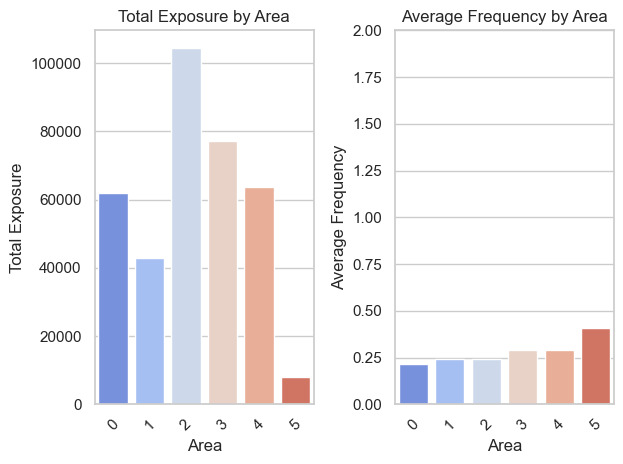

In [44]:
plotBarChart(df_transformed,'Area',2)

<Figure size 2000x800 with 0 Axes>

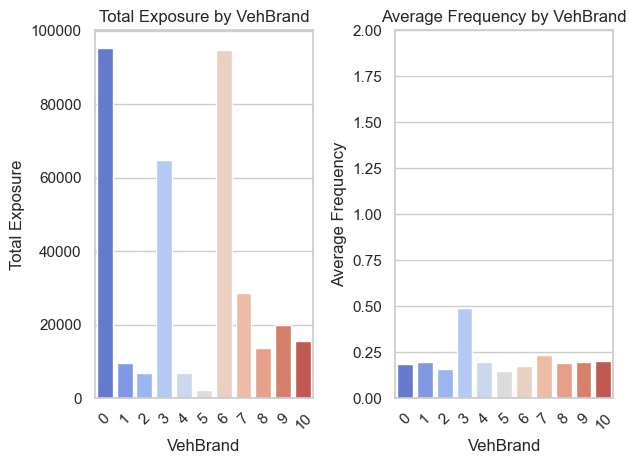

In [45]:
plotBarChart(df_transformed,'VehBrand',2)

<Figure size 2000x800 with 0 Axes>

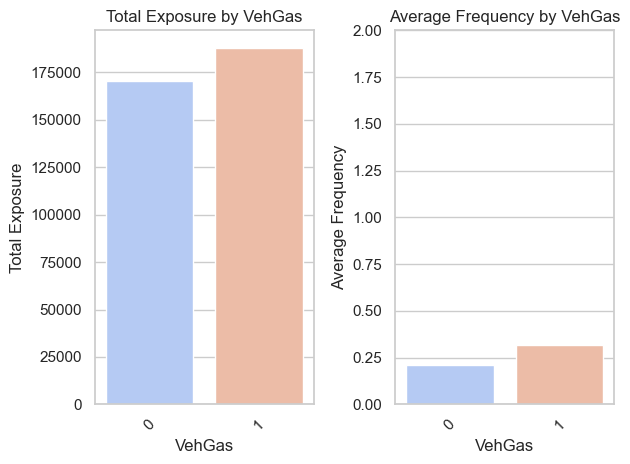

In [46]:
plotBarChart(df_transformed,'VehGas',2)

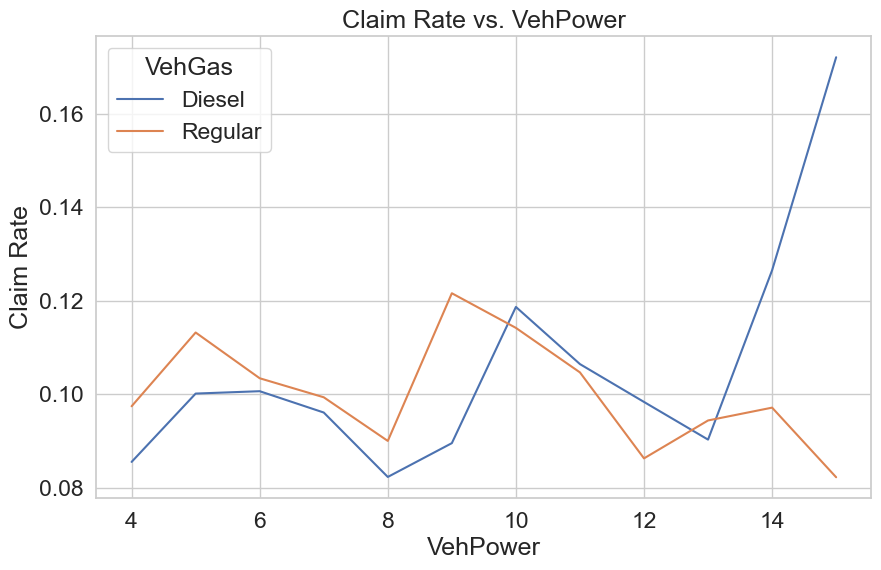

In [47]:
claim_rate_data = df.groupby(['VehGas', 'VehPower']).agg(
    claim_rate=('ClaimNb', 'sum')).reset_index()
claim_rate_data['claim_rate'] /= df.groupby(['VehGas', 'VehPower'])['Exposure'].sum().values

# Plotting
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(10, 6))

sns.lineplot(x='VehPower', y='claim_rate', hue='VehGas', data=claim_rate_data)
plt.title('Claim Rate vs. VehPower')
plt.xlabel('VehPower')
plt.ylabel('Claim Rate')
plt.show()


<Figure size 2000x800 with 0 Axes>

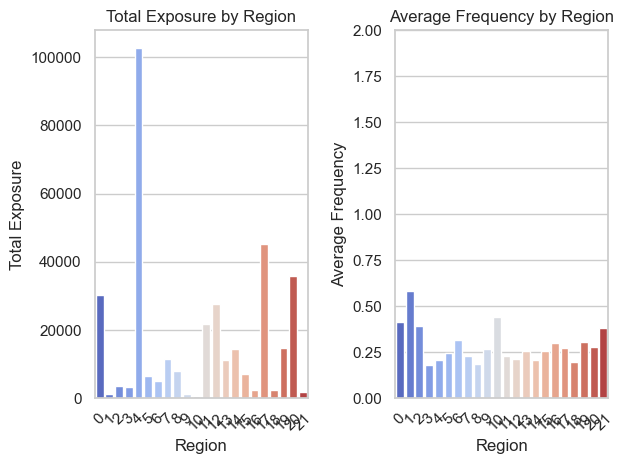

In [48]:
plotBarChart(df_transformed,'Region',2)

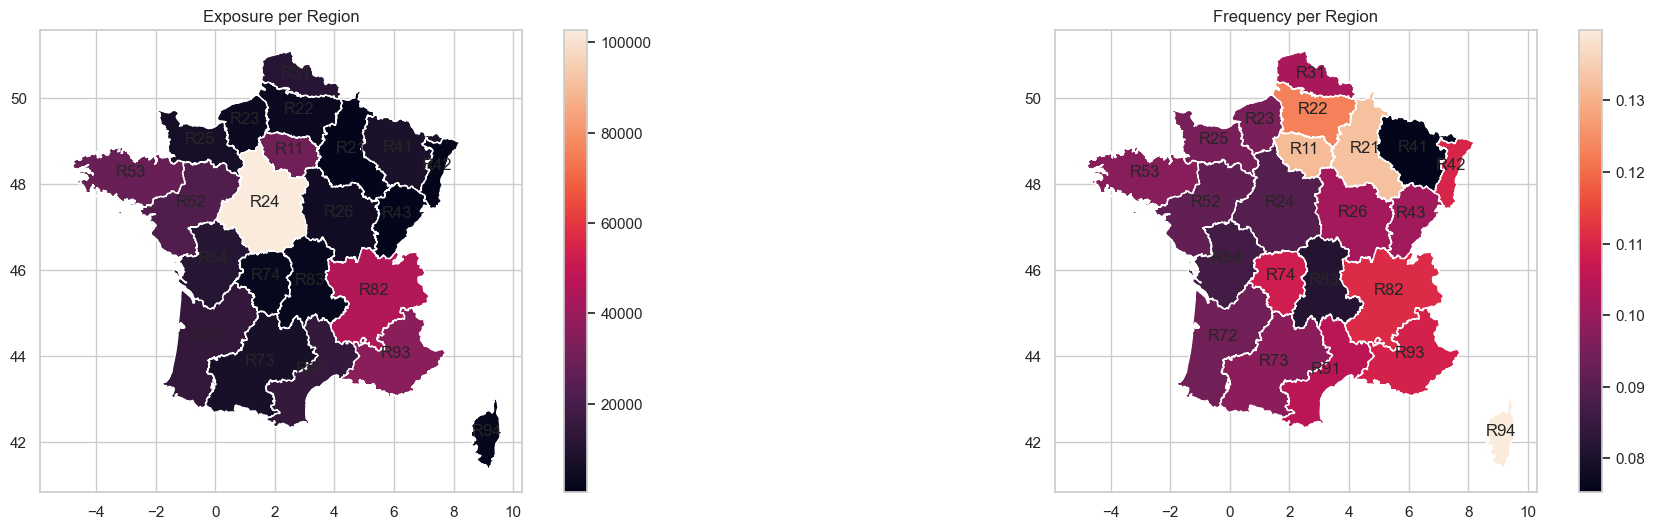

In [49]:
gdf_france = gpd.read_file("data/regions-20140306-100m.shp")
gdf_france = gdf_france[~gdf_france["nom"].isin(["Guadeloupe", "Guyane", "La Réunion", "Martinique", "Mayotte"])]
gdf_france['Region'] = "R" + gdf_france['code_insee']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12*2, 6))

tmp = (df.groupby(['Region'])['Exposure', 'ClaimNb']
          .sum()
          .assign(frequency = lambda x: x['ClaimNb']/x['Exposure'])
         )
tmp = gdf_france.merge(tmp, on='Region', how='right')
tmp.plot(column='Exposure', legend=True, ax=axes[0])
tmp.plot(column='frequency', legend=True, ax=axes[1])
tmp.apply(lambda x: axes[0].annotate(text=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
tmp.apply(lambda x: axes[1].annotate(text=x['Region'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

axes[0].set_title('Exposure per Region');
axes[1].set_title('Frequency per Region');


#### Insights
- DrivAge and VehAge ARE VERY IMPORTANT, they have non-linear relationship with the outcome
- especially, the lowest values of DrivAge and VehAge have higher claim numbers,i.e. high order terms are important
- Regular VehGas and low VehAge=0 maybe a good interaction
- VehPower and VehAge have a non-linear relationship with the outcome
- VehPower = 15, 5, 9 ,10's new cars have higher claim numbers
- new cars and older drivers have higher BONUSMALUS  are more likely to have higher claim numbers


In [52]:
df_corr=df_transformed.copy()
label_encoders = {}
linear_corr = df_corr.corr(method='pearson')
nonlinear_corr = df_corr.corr(method='spearman')

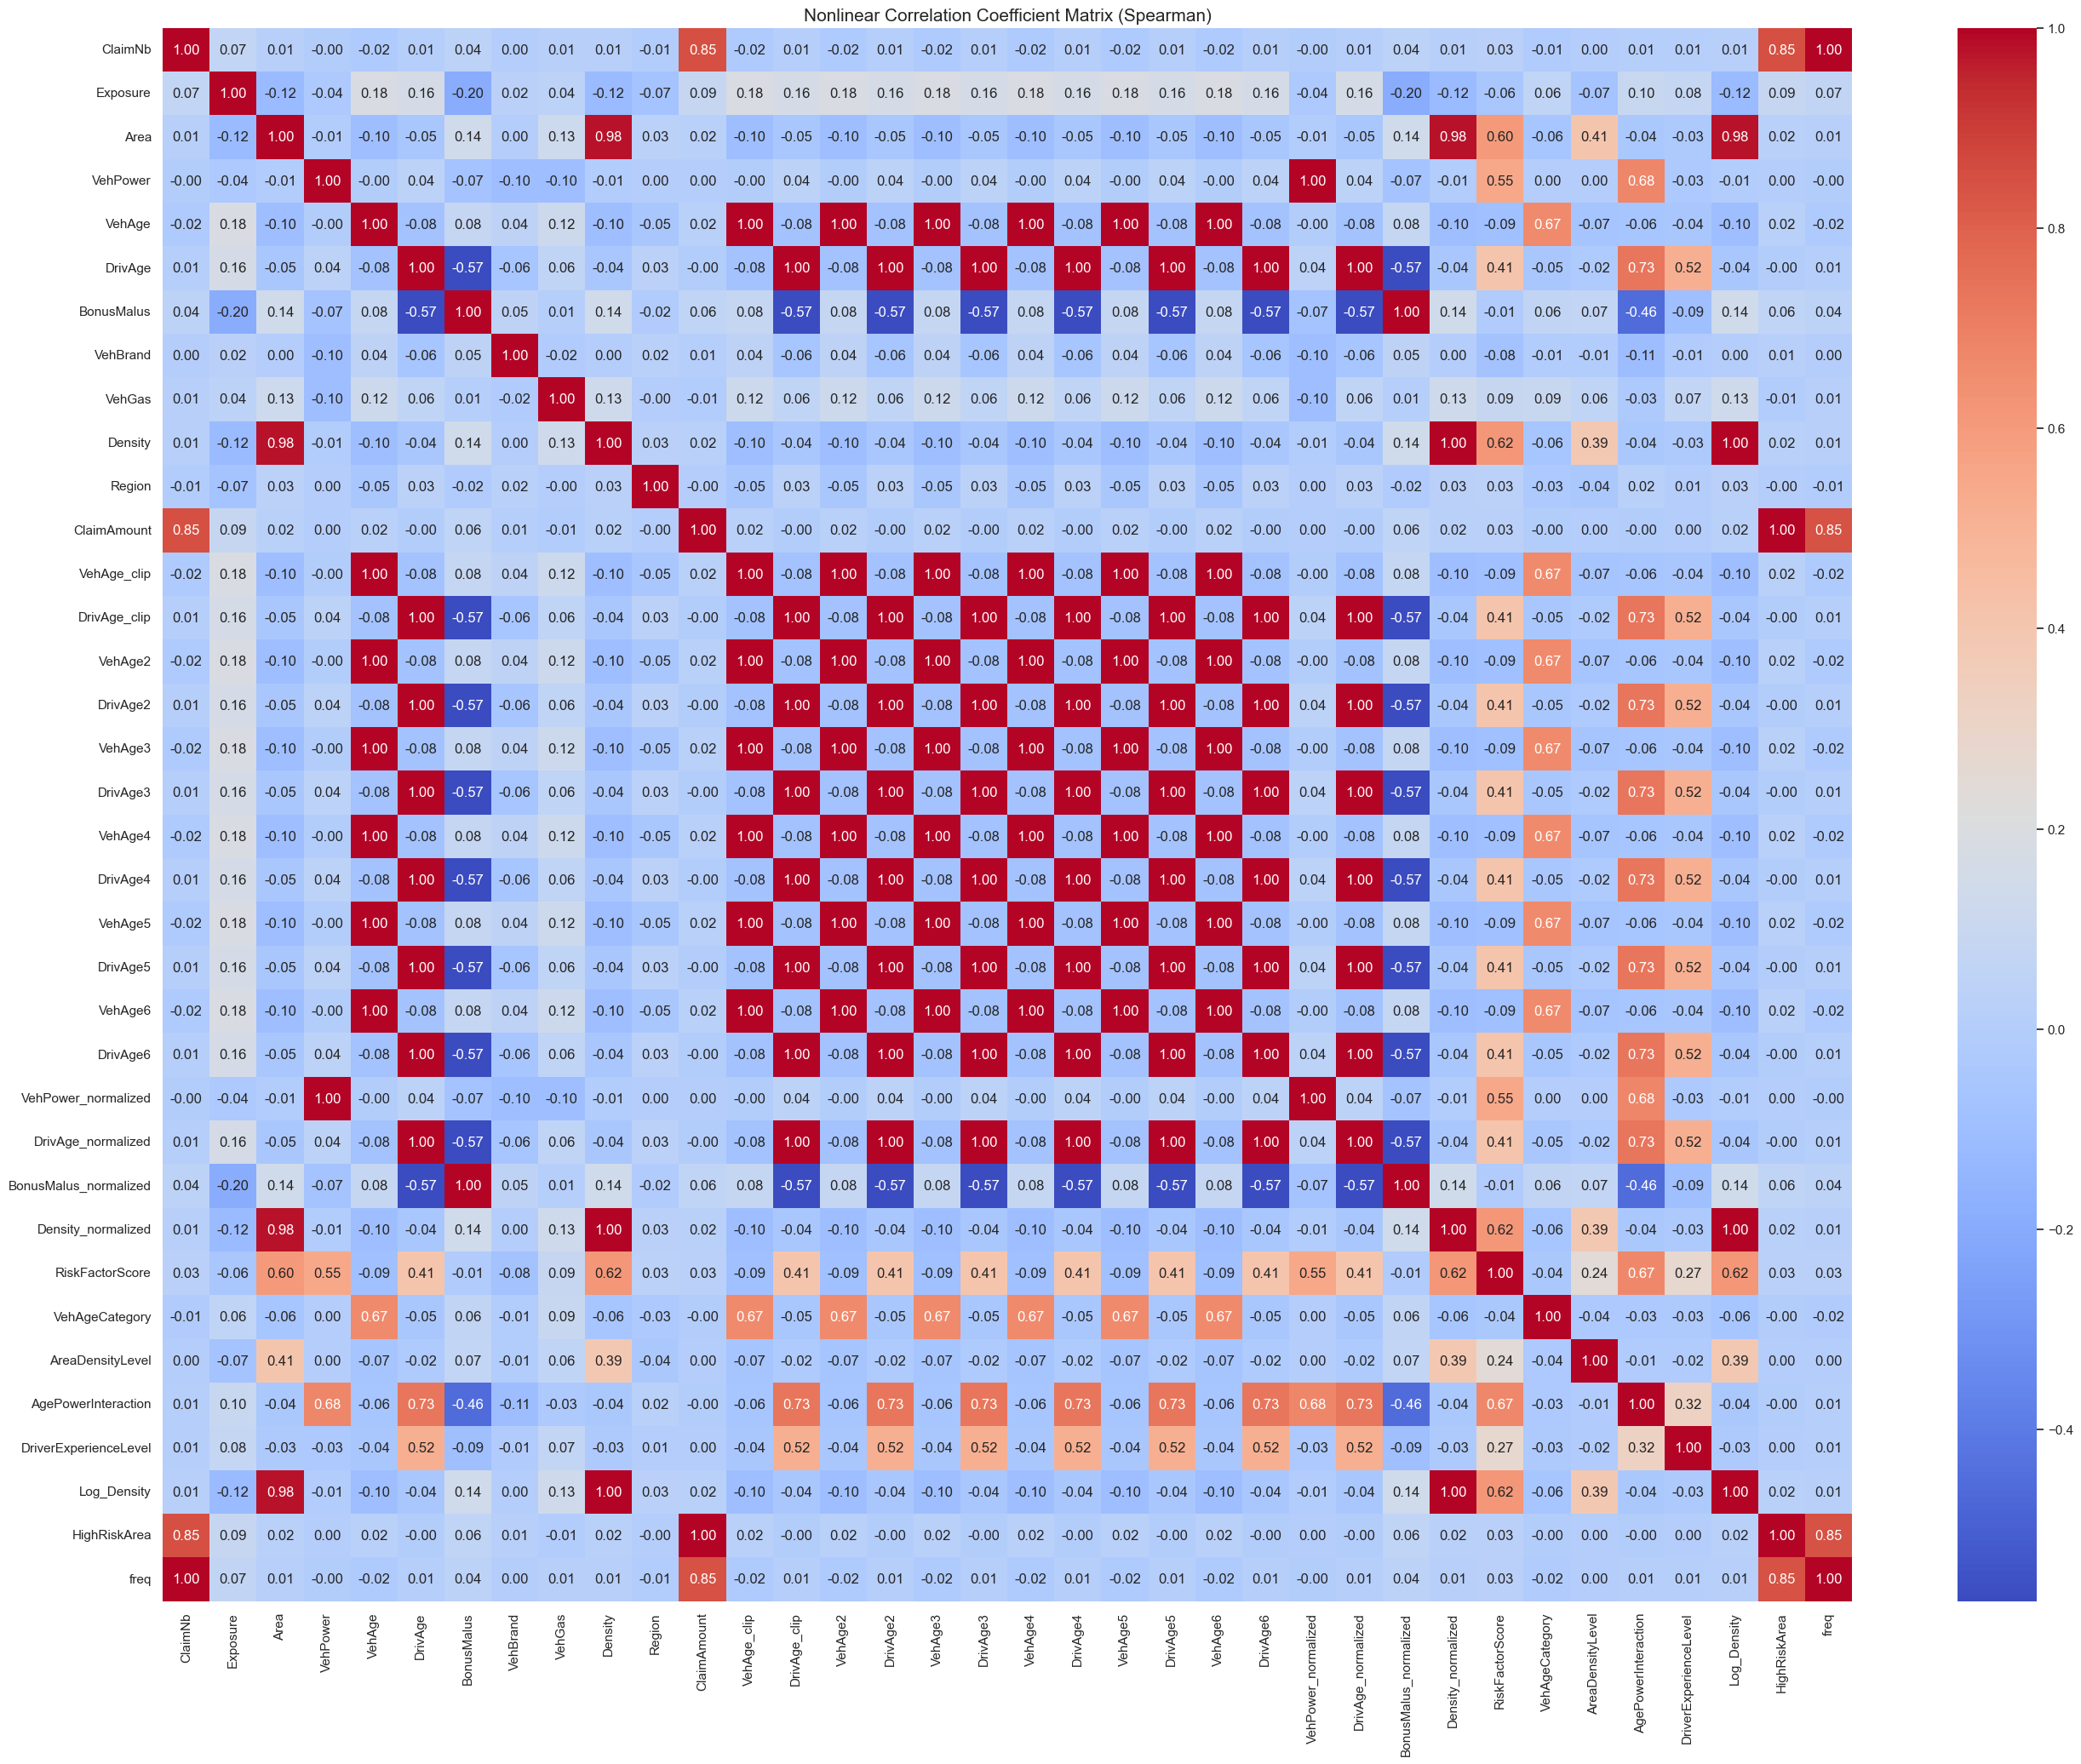

In [53]:
# Set up the matplotlib figure for nonlinear correlation matrix
plt.figure(figsize=(32, 24))
plt.title('Nonlinear Correlation Coefficient Matrix (Spearman)', fontsize=15)
sns.heatmap(nonlinear_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()

In [50]:
#The End